In [ ]:
!pip install transformers
!pip install datasets
!pip install accelerate -U

#### Load Dataset

In [4]:
from zipfile import ZipFile
import os

os.chdir(r'/content')
with ZipFile(r"/content/drive/MyDrive/Monadical/potato_plans_diseases.zip", 'r') as f:
    f.extractall(path="images")

os.rename(r'/content/images/PLD_3_Classes_256/Training', r'/content/images/PLD_3_Classes_256/train')
os.rename(r'/content/images/PLD_3_Classes_256/Testing', r'/content/images/PLD_3_Classes_256/test')
os.rename(r'/content/images/PLD_3_Classes_256/Validation', r'/content/images/PLD_3_Classes_256/validation')


In [39]:
from datasets import load_dataset

dataset = load_dataset("/content/images/PLD_3_Classes_256")

Resolving data files:   0%|          | 0/3251 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/416 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/405 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

In [40]:
labels = dataset["train"].features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = str(i)
    id2label[str(i)] = label

#### Preprocessing

In [41]:
from transformers import AutoFeatureExtractor

feature_extractor = AutoFeatureExtractor.from_pretrained("google/vit-base-patch16-224-in21k")

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [42]:
from torchvision.transforms import RandomResizedCrop, RandomRotation, Compose, Normalize, ToTensor

normalize = Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)
_transforms = Compose([RandomRotation(degrees=(0, 180)), RandomResizedCrop(size=(224,224)), ToTensor(), normalize])

In [43]:
def transforms(examples):
    examples["pixel_values"] = [_transforms(img.convert("RGB")) for img in examples["image"]]
    del examples["image"]
    return examples

In [44]:
dataset['train'] = dataset['train'].with_transform(transforms)
dataset['validation'] = dataset['validation'].with_transform(transforms)

In [11]:
from transformers import DefaultDataCollator

data_collator = DefaultDataCollator()

#### Training

In [12]:
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer

model = AutoModelForImageClassification.from_pretrained(
    "google/vit-base-patch16-224-in21k",
    num_labels=len(labels),
    id2label=id2label,
    label2id=label2id,
)

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.weight', 'pooler.dense.bias']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [20]:
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    num_train_epochs=2,
    fp16=False,
    logging_steps=10,
    save_total_limit=2,
    remove_unused_columns=False,
)

In [21]:
def calculate_learning_rate(val):
    if val == 1:
        return 5e-5
    elif val == 2:
        return 1e-5
    elif val == 3:
        return 5e-6
    else:
        return 1e-6

def calculate_batch_size(val):
    if val == 1:
        return 16
    elif val == 2:
        return 8
    else:
        return 4

for batch in range(4):

    # Calculate the desired learning rate and batch size based on the current epoch
    current_learning_rate = calculate_learning_rate(batch)
    current_batch_size = calculate_batch_size(batch)

    training_args.set_dataloader(train_batch_size=current_batch_size)
    training_args.set_optimizer(learning_rate=current_learning_rate)

    trainer = Trainer(
        model=model,
        args=training_args,
        data_collator=data_collator,
        train_dataset=dataset["train"],
        eval_dataset=dataset["validation"],
        tokenizer=feature_extractor,
    )

    trainer.train()

In [17]:
trainer.save_model('/content/drive/MyDrive/Monadical/model.pt')

#### Inference

In [36]:
from transformers import AutoImageProcessor,AutoModelForImageClassification

image_processor = AutoImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")
model = AutoModelForImageClassification.from_pretrained("/content/drive/MyDrive/Monadical/model.pt")

In [37]:
from transformers import pipeline

pipe = pipeline("image-classification",
                model=model,
                feature_extractor=image_processor)

In [45]:
pipe(dataset['test'][0]['image'])

[{'score': 0.9967058300971985, 'label': 'Early_Blight'},
 {'score': 0.002277331193909049, 'label': 'Late_Blight'},
 {'score': 0.0010168676963075995, 'label': 'Healthy'}]

#### Evaluation

In [98]:
result = trainer.evaluate()
result

{'eval_loss': 0.09124355763196945,
 'eval_runtime': 2.3022,
 'eval_samples_per_second': 180.697,
 'eval_steps_per_second': 22.587,
 'epoch': 8.0}

In [99]:
import os

def absoluteFilePaths(directory):
    for dirpath,_,filenames in os.walk(directory):
        for f in filenames:
            yield os.path.abspath(os.path.join(dirpath, f))

test_images = [img for img in absoluteFilePaths('/content/images/PLD_3_Classes_256/test')]

predictions = pipe(test_images)

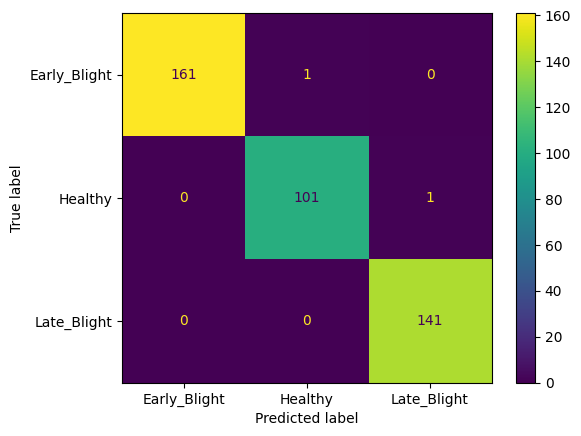

In [45]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

y_true = [ point['label'] for point in dataset['test']]
y_pred = [int(label2id[pred[0]['label']]) for pred in predictions]
confusion_matrix = confusion_matrix(y_true, y_pred)

cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = labels)
cm_display.plot()
plt.show()

In [46]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Calculate evaluation metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred,average=None)
recall = recall_score(y_true, y_pred,average=None)
f1 = f1_score(y_true, y_pred,average=None)

# Print the evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)


Accuracy: 0.9950617283950617
Precision: [1.         0.99019608 0.99295775]
Recall: [0.99382716 0.99019608 1.        ]
F1-score: [0.99690402 0.99019608 0.99646643]
